In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import time
import requests
from sklearn.preprocessing import LabelEncoder
from matplotlib.ticker import FuncFormatter

pd.set_option('display.max_columns', None)

## Code for generating and validating descriptive stats for August presentation

Import the dataset of cleaned public housing data with fire data attached, and the full FEMA dataset for all matches, which is less clean but contains all infromation from the basicincident, incidentaddress, and fireincident tables provided by NFIRS.

In [2]:
m = pd.read_csv('./ph_fires_matched_2.1.csv')

In [3]:
m['total_indoor'] = m[[x for x in m.columns if 'building_fires_' in x]].sum(axis=1)
m['money_lost'] = m[[x for x in m.columns if 'prop_loss' in x]].sum(axis=1) + m[[x for x in m.columns if 'cont_loss_' in x]].sum(axis=1)

In [4]:
m['inc_type111_sum'] = m[[x for x in m.columns if 'inc_type_111' in x]].sum(axis=1)


In [5]:
m[(m.std_city == 'NEW YORK')&(m.building_type_code_es != 1)].inc_type111_sum.sum()

9.0

In [6]:
m[(m.std_city != 'NEW YORK')&(m.building_type_code_es == 1)].inc_type111_sum.sum()

678.0

In [7]:
full = pd.read_csv('./full_fema_matches.csv')
keys = full.INCIDENT_KEY.unique()

conn = sqlite3.Connection('./data/nfirs/fire_data.db')

placeholders = ', '.join(['?'] * len(keys))
query = f"SELECT * FROM incident_address ia left join basic_incident bi using (INCIDENT_KEY) left join fire_incident fi using (INCIDENT_KEY) WHERE ia.INCIDENT_KEY IN ({placeholders})"
f = pd.read_sql_query(query, conn, params=keys.tolist())

In [8]:
f.columns = [x.lower() for x in f.columns]

In [9]:
f['prop_plus_cont_loss'] = f.prop_loss + f.cont_loss

In [10]:
from matplotlib.colors import LinearSegmentedColormap

colors = ["darkred", "firebrick", "red", "lightcoral", "salmon"]
cmap = LinearSegmentedColormap.from_list("custom_fire", colors, N=5)

We'll start by looking at the total number of fires in public housing.

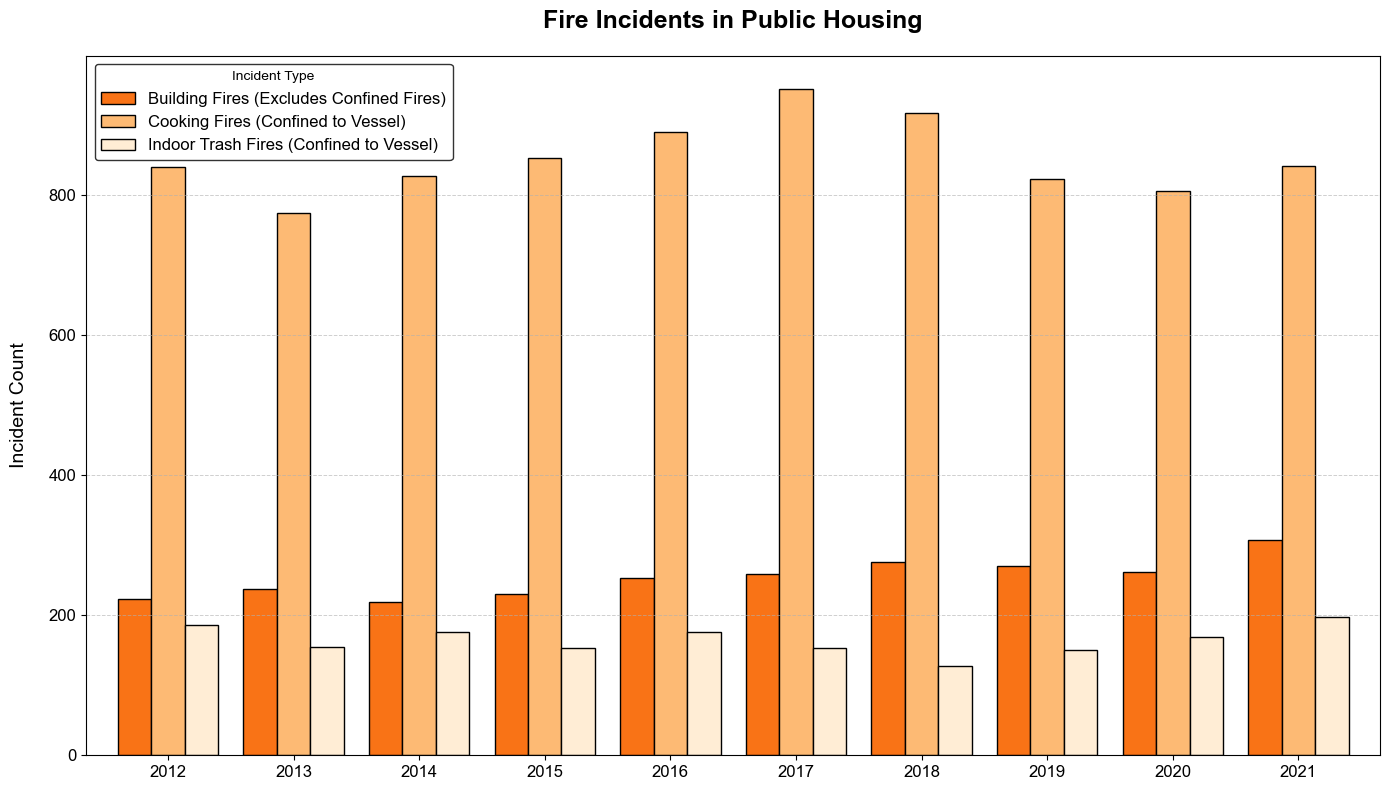

In [21]:
injury_series = f[f.inc_type.isin([111, 113, 118])].groupby(['inc_year', 'inc_type']).size()
injury_df = injury_series.unstack(level=-1).fillna(0)

type_mapping = {
    111: 'Building Fires (Excludes Confined Fires)',
    113: 'Cooking Fires (Confined to Vessel)',
    118: 'Indoor Trash Fires (Confined to Vessel)'
}

injury_df = injury_df.rename(columns=type_mapping)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
colors = {'Building Fires (Excludes Confined Fires)': '#f97316', 'Cooking Fires (Confined to Vessel)': '#fdba74', 'Indoor Trash Fires (Confined to Vessel)': '#ffedd5'}

ax = injury_df.plot(kind='bar', figsize=(14, 8), width=0.8, color=colors, edgecolor='black')
ax.set_title('Fire Incidents in Public Housing', fontsize=18, fontweight='bold', pad=20)
ax.set_ylabel('Incident Count', fontsize=14, labelpad=15)
ax.set_xlabel('', fontsize=14, labelpad=15)

ax.tick_params(axis='both', which='major', labelsize=12, rotation=0)
ax.legend(title="Incident Type", fontsize=12, frameon=True, edgecolor='black', loc='upper left')
ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6)
plt.tight_layout()
plt.show()


We'll also look at total property lost to fires. 

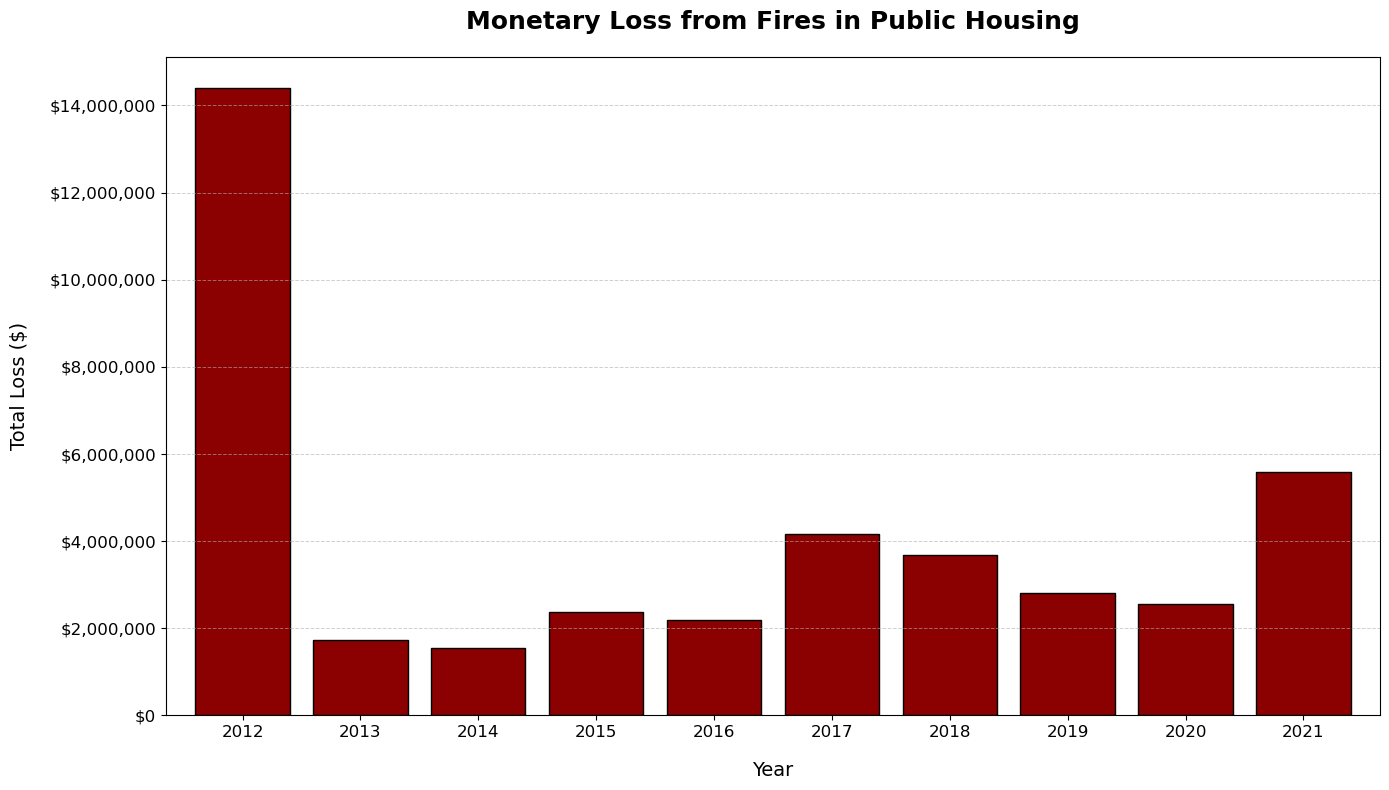

In [ ]:
loss_series = f.groupby(['inc_year']).prop_plus_cont_loss.sum()

ax = loss_series.plot(kind='bar', figsize=(14, 8), width=0.8, colormap=cmap, edgecolor='black')
ax.set_title('Monetary Loss from Fires in Public Housing', fontsize=18, fontweight='bold', pad=20)
ax.set_ylabel('Total Loss ($)', fontsize=14, labelpad=15)
ax.set_xlabel('Year', fontsize=14, labelpad=15)
ax.tick_params(axis='both', which='major', labelsize=12, rotation=0)
ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6)
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,}".format(int(x))))
plt.tight_layout()
plt.show()


Same thing for deaths.

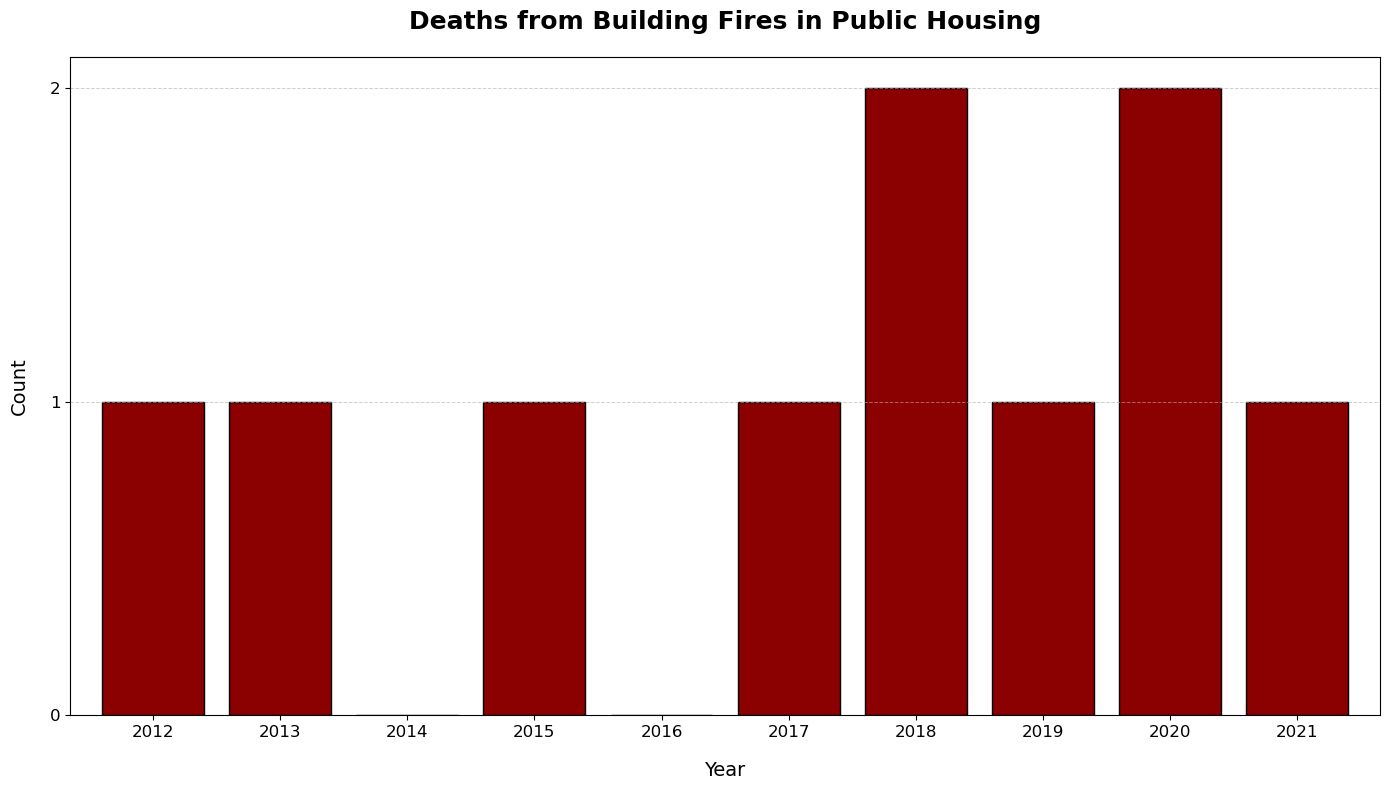

In [ ]:
death_series = f[(f.oth_death > 0)].groupby(['inc_year']).size()

all_years = range(2012, 2021 + 1)
death_df = death_series.reindex(all_years, fill_value=0)

ax = death_df.plot(kind='bar', figsize=(14, 8), width=0.8, colormap=cmap, edgecolor='black')
ax.set_title('Deaths from Building Fires in Public Housing', fontsize=18, fontweight='bold', pad=20)
ax.set_ylabel('Count', fontsize=14, labelpad=15)
ax.set_xlabel('Year', fontsize=14, labelpad=15)
ax.tick_params(axis='both', which='major', labelsize=12, rotation=0)
ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6)

max_val = death_df.max()
ax.set_yticks(np.arange(0, max_val + 1, 1))

plt.tight_layout()

plt.show()


And something similar for injuries as well.

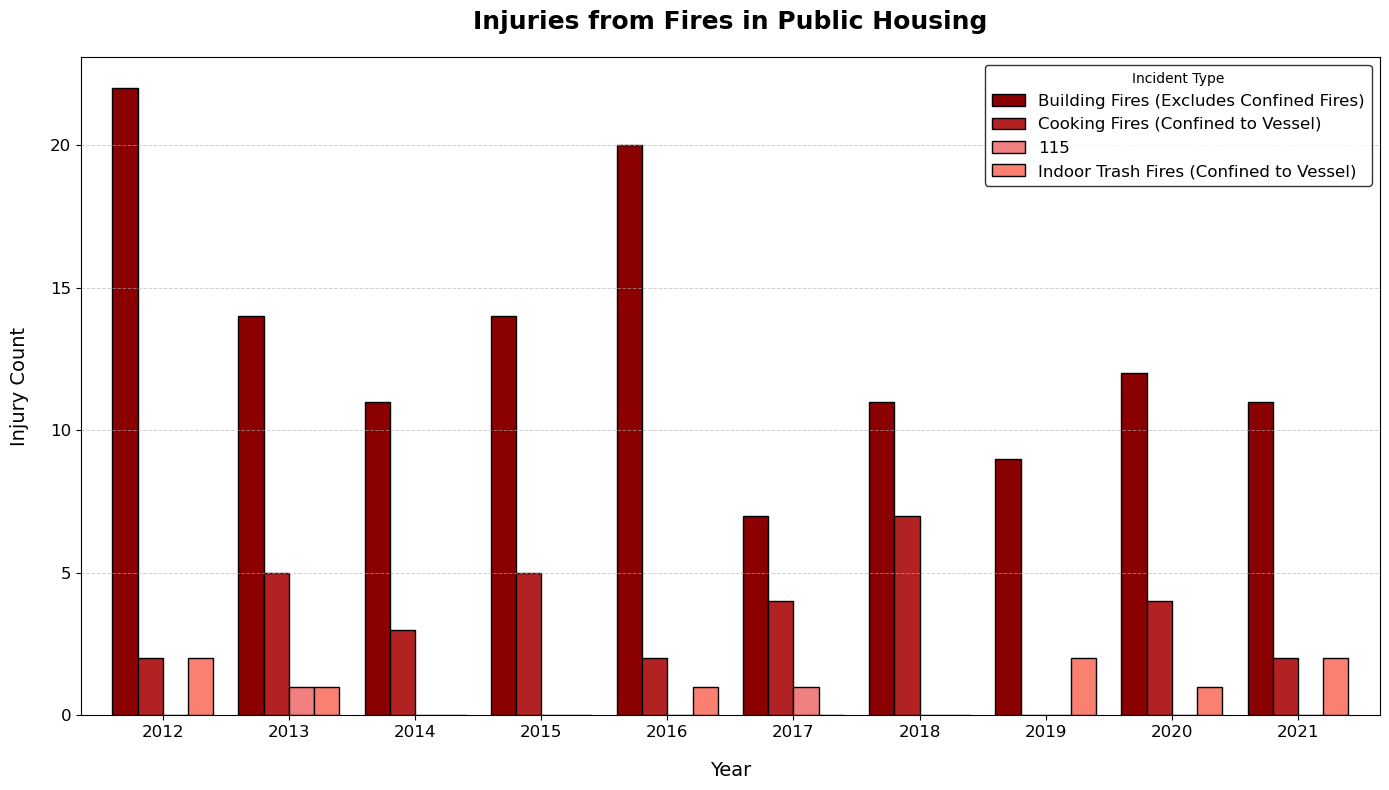

In [ ]:
injury_series = f[(f.oth_inj > 0) | (f.ff_inj > 0)].groupby(['inc_year', 'inc_type']).size()
injury_df = injury_series.unstack(level=-1).fillna(0)

type_mapping = {
    111: 'Building Fires (Excludes Confined Fires)',
    113: 'Cooking Fires (Confined to Vessel)',
    118: 'Indoor Trash Fires (Confined to Vessel)'
}

injury_df = injury_df.rename(columns=type_mapping)

ax = injury_df.plot(kind='bar', figsize=(14, 8), width=0.8, colormap=cmap, edgecolor='black')
ax.set_title('Injuries from Fires in Public Housing', fontsize=18, fontweight='bold', pad=20)
ax.set_ylabel('Injury Count', fontsize=14, labelpad=15)
ax.set_xlabel('Year', fontsize=14, labelpad=15)
ax.tick_params(axis='both', which='major', labelsize=12, rotation=0)
ax.legend(title="Incident Type", fontsize=12, frameon=True, edgecolor='black', loc='upper right')
ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6)
plt.tight_layout()
plt.show()


Let's look at all the building fires and see how they originated. (Cooking is the most common cause.)

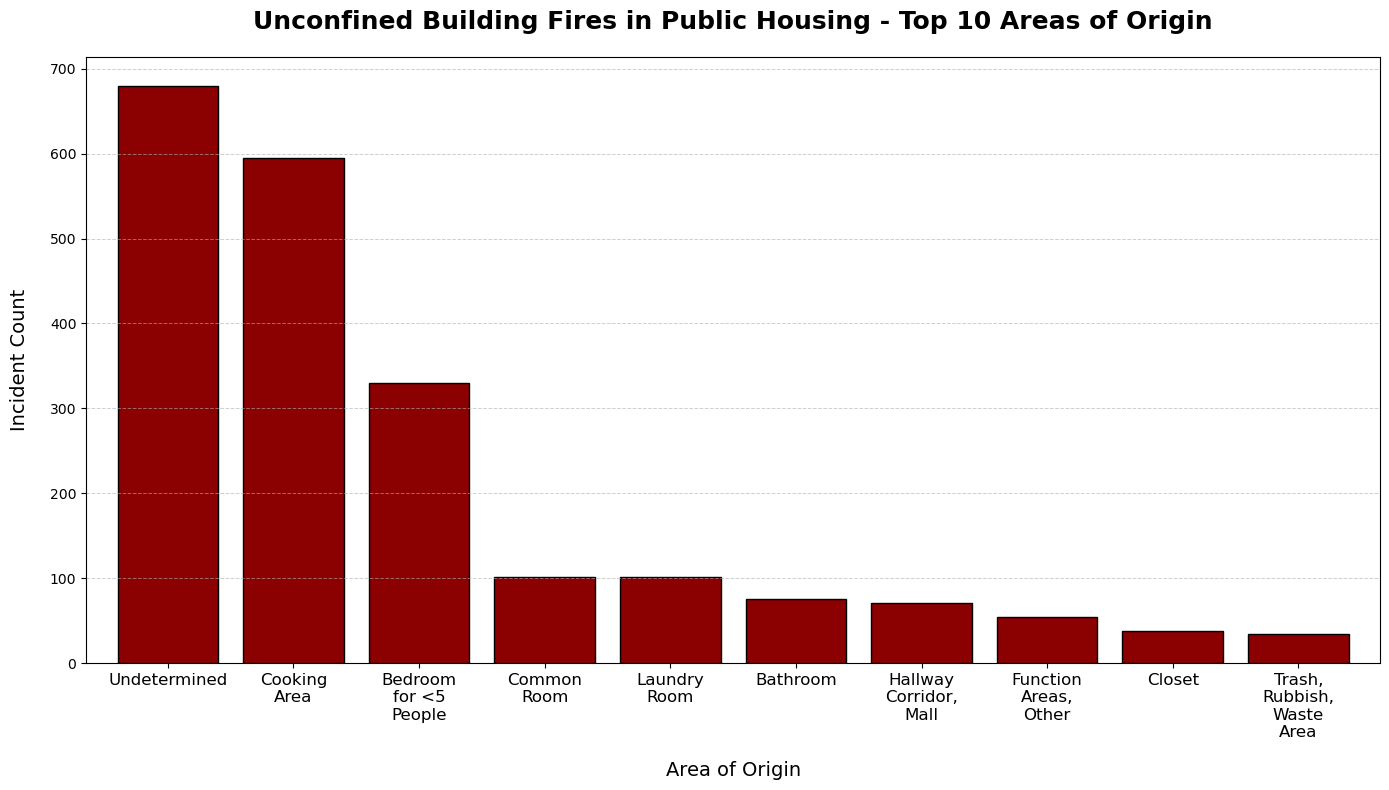

In [ ]:
f.area_orig = f.area_orig.fillna('UU')
f.loc[f.area_orig == '01', 'area_orig'] = 'UU'

area_labels = {
    'UU': 'Undetermined',
    '24': 'Cooking\nArea',
    '21': 'Bedroom\nfor <5\nPeople',
    '26': 'Laundry\nRoom',
    '14': 'Common\nRoom',
    '25': 'Bathroom',
    '20': 'Function\nAreas,\nOther',
    '42': 'Closet',
    '76': 'Wall Surface,\nExterior',
    '74': 'Attic',
    '03': 'Hallway\nCorridor,\nMall',
    '46': 'Trash,\nRubbish,\nWaste\nArea'
}

top_areas = f[f.inc_type == 111].groupby('area_orig').size().sort_values(ascending=False).head(10)
top_areas = top_areas.rename(index=area_labels)

ax = top_areas.plot(kind='bar', figsize=(14, 8), width=0.8, colormap=cmap, edgecolor='black')
ax.set_title('Unconfined Building Fires in Public Housing - Top 10 Areas of Origin', fontsize=18, fontweight='bold', pad=20)
ax.set_ylabel('Incident Count', fontsize=14, labelpad=15)
ax.set_xlabel('Area of Origin', fontsize=14, labelpad=15)
ax.tick_params(axis='x', which='major', labelsize=12, rotation=0)

ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6)
plt.tight_layout()
plt.show()

We'll do something similar for the item first ignited by the fire.

In [ ]:
f.groupby('heat_sourc').size().sort_values(ascending=False)

heat_sourc
UU    1166
12     669
10     512
00     358
11     301
40     198
13     137
65     126
61     110
81     105
60     102
43      64
66      60
64      29
42      19
82      17
63      17
80      16
54      16
56      15
84      13
69       8
41       7
72       5
73       5
97       5
50       4
62       2
70       2
83       1
dtype: int64

In [ ]:
factor_cols = [
    'AREA_ORIG',
    'HEAT_SOURC',
    'FIRST_IGN',
    'CONF_ORIG',
    'TYPE_MAT',
    'CAUSE_IGN',
    'FACT_IGN_1',
    'FACT_IGN_2'
]
factor_cols = [x.lower() for x in factor_cols]

f[factor_cols] = f[factor_cols].fillna('UU')

In [ ]:
f.groupby(factor_cols[2]) \
    .size().sort_values(ascending=False)

first_ign
UU    9813
76    1297
96     307
00     118
31     111
      ... 
56       1
24       1
57       1
68       1
53       1
Length: 65, dtype: int64

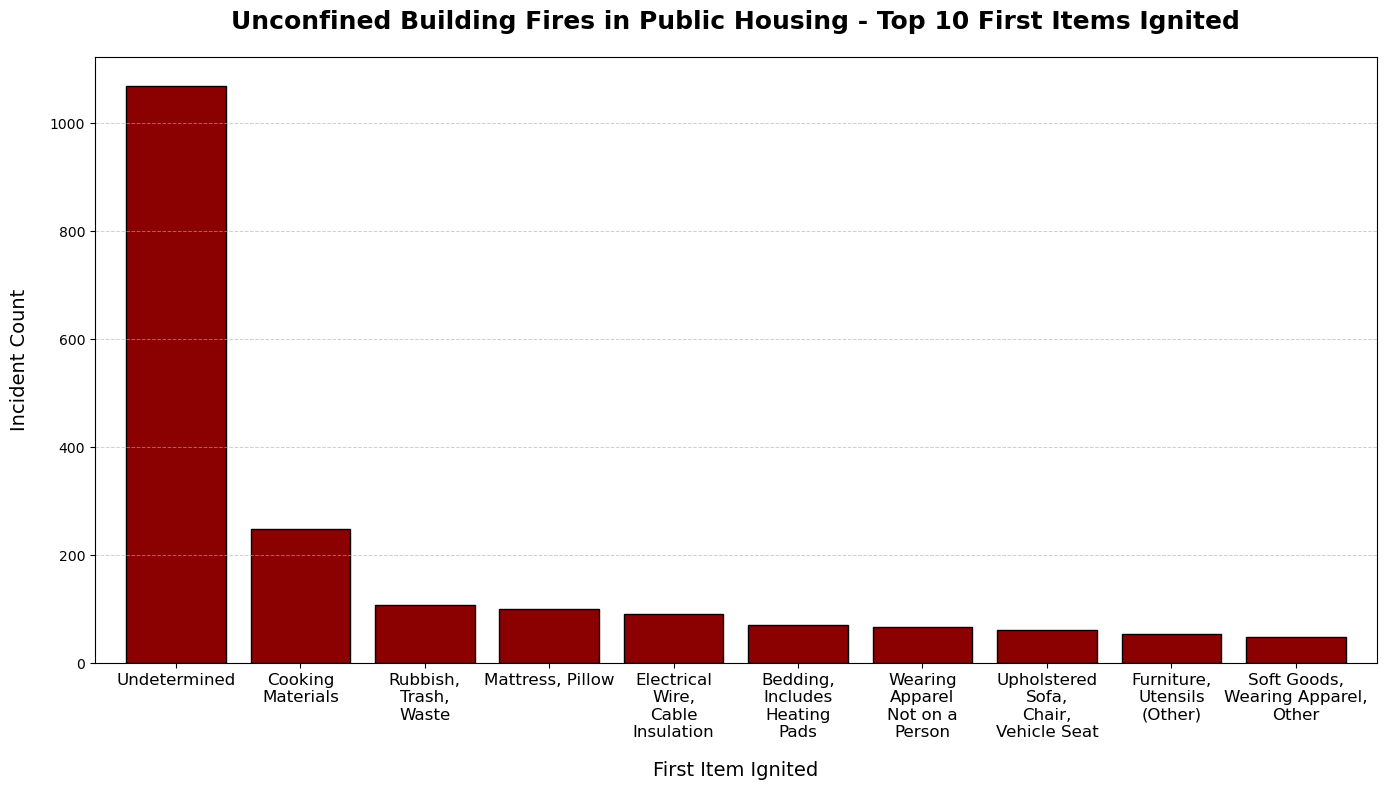

In [ ]:
f['first_ign'] = f.first_ign.fillna('UU')

ign_labels = {
    'UU': 'Undetermined',
    '76': 'Cooking\nMaterials',
    '81': 'Electrical\nWire,\nCable\nInsulation',
    '31': 'Mattress, Pillow',
    '32': 'Bedding,\nIncludes\nHeating\nPads',
    '34': 'Wearing\nApparel\nNot on a\nPerson',
    '21': 'Upholstered\nSofa,\nChair,\nVehicle Seat',
    '20': 'Furniture,\nUtensils\n(Other)',
    '96': 'Rubbish,\nTrash,\nWaste',
    '23': 'Cabinetry',
    '30': 'Soft Goods,\nWearing Apparel,\nOther'
}

top_ign = f[f.inc_type == 111].groupby('first_ign').size().sort_values(ascending=False).head(10)
top_ign = top_ign.rename(index=ign_labels)

ax = top_ign.plot(kind='bar', figsize=(14, 8), width=0.8, colormap=cmap, edgecolor='black')
ax.set_title('Unconfined Building Fires in Public Housing - Top 10 First Items Ignited', fontsize=18, fontweight='bold', pad=20)
ax.set_ylabel('Incident Count', fontsize=14, labelpad=15)
ax.set_xlabel('First Item Ignited', fontsize=14, labelpad=15)
ax.tick_params(axis='x', which='major', labelsize=12, rotation=0)

ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6)
plt.tight_layout()
plt.show()

A metric of fire severity.

In [ ]:
f[(f.oth_inj > 0)|(f.ff_inj > 0)].groupby('aes_pres').size().sort_values(ascending=False)

aes_pres
N    98
1    39
U     3
2     2
dtype: int64

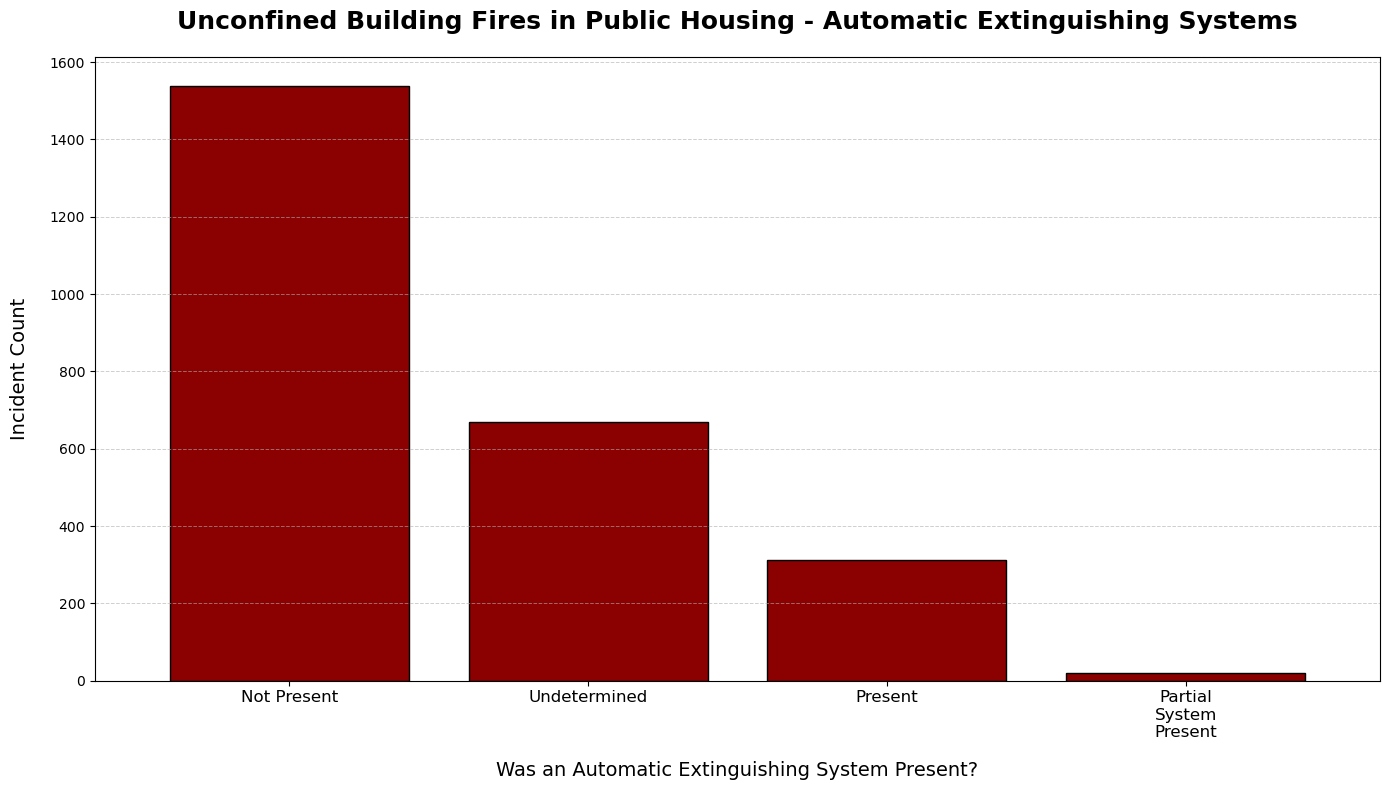

In [ ]:
f['aes_pres'] = f.aes_pres.fillna('U')

aes_labels = {
    'U': 'Undetermined',
    'N': 'Not Present',
    '2': 'Partial\nSystem\nPresent',
    '1': 'Present'
}

top_aes = f[f.inc_type == 111].groupby('aes_pres').size().sort_values(ascending=False).head(10)
top_aes = top_aes.rename(index=aes_labels)

ax = top_aes.plot(kind='bar', figsize=(14, 8), width=0.8, colormap=cmap, edgecolor='black')
ax.set_title('Unconfined Building Fires in Public Housing - Automatic Extinguishing Systems', 
    fontsize=18, fontweight='bold', pad=20)
ax.set_ylabel('Incident Count', fontsize=14, labelpad=15)
ax.set_xlabel('Was an Automatic Extinguishing System Present?', fontsize=14, labelpad=15)
ax.tick_params(axis='x', which='major', labelsize=12, rotation=0)

ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6)
plt.tight_layout()
plt.show()

### Distribution of fires between highrise/houses.

In [ ]:
m['total_111'] = m[[x for x in m.columns if 'inc_type_111_' in x]].sum(axis=1)
m['total_building_fires'] = m[[x for x in m.columns if 'building_fires_' in x]].sum(axis=1)

Highrise/ES buildings are about a fourth of public housing buildings.

In [ ]:
len(m[(m.building_type_code_es == 1)]), len(m[(m.building_type_code_es != 1)])

(4021, 175022)

However, they have around 40% of all unconfined building fires.

In [ ]:
m[(m.building_type_code_es == 1) ].total_111.sum(), m[(m.building_type_code_es != 1)].total_111.sum()

(831.0, 1709.0)

And they have the majority of fires overall.

In [ ]:
m[m.building_type_code_es == 1].total_building_fires.sum(), m[(m.building_type_code_es != 1)].total_building_fires.sum()

(8457.0, 4496.0)

Fires in a given year are rare, especially in single family housing

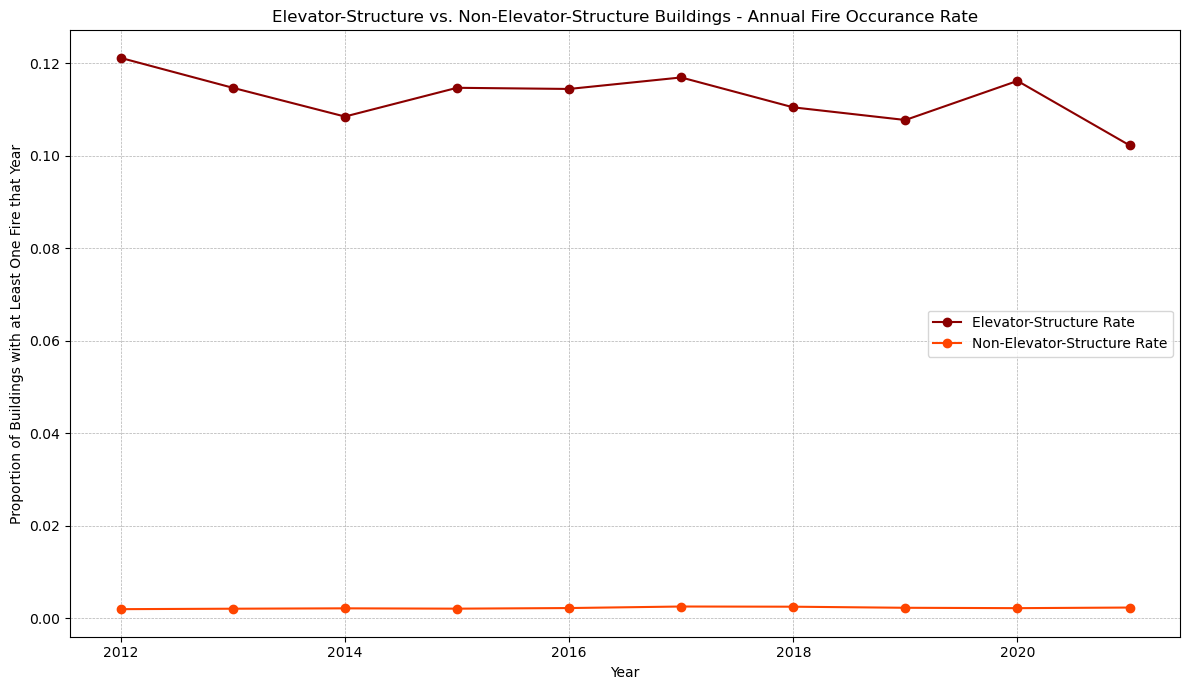

In [ ]:
es = []
for year in range(2012, 2022):
    es.append((year, len(m[(m.building_type_code_es == 1) & (m[f'building_fires_{year}'] > 0)]) / len(m[m.building_type_code_es == 1]))
)
    
nones = []
for year in range(2012, 2022):
    nones.append((year, len(m[(m.building_type_code_es != 1) & (m[f'building_fires_{year}'] > 0)]) / len(m[m.building_type_code_es != 1])))

es = pd.DataFrame(es, columns=['year', 'elevator_structure'])
nones = pd.DataFrame(nones, columns=['year', 'nonelevator_structure'])
o = es.merge(nones, on='year')
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))

# Plotting highrise_rate and nonhighrise_rate
plt.plot(o['year'], o['elevator_structure'], marker='o', label='Elevator-Structure Rate', color='darkred')
plt.plot(o['year'], o['nonelevator_structure'], marker='o', label='Non-Elevator-Structure Rate', color='orangered')

# Setting the title and labels
plt.title('Elevator-Structure vs. Non-Elevator-Structure Buildings - Annual Fire Occurance Rate')
plt.xlabel('Year')
plt.ylabel('Proportion of Buildings with at Least One Fire that Year')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

# Displaying the plot
plt.tight_layout()
plt.show()


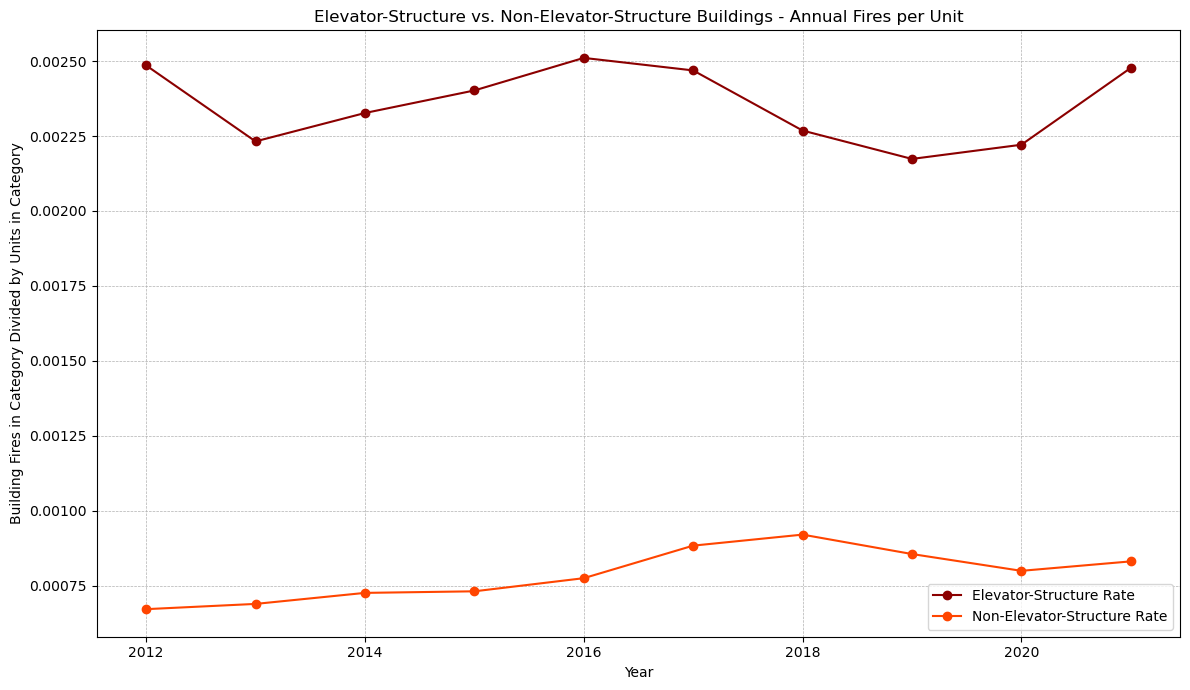

In [ ]:
es = []
for year in range(2012, 2022):
    es.append((year, m[m.building_type_code_es == 1][f'building_fires_{year}'].sum() / m[m.building_type_code_es == 1].total_units.sum())
)
    
nones = []
for year in range(2012, 2022):
    nones.append((year, m[m.building_type_code_es != 1][f'building_fires_{year}'].sum() / m[m.building_type_code_es != 1].total_units.sum()))

es = pd.DataFrame(es, columns=['year', 'elevator_structure'])
nones = pd.DataFrame(nones, columns=['year', 'nonelevator_structure'])
o = es.merge(nones, on='year')
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))

# Plotting highrise_rate and nonhighrise_rate
plt.plot(o['year'], o['elevator_structure'], marker='o', label='Elevator-Structure Rate', color='darkred')
plt.plot(o['year'], o['nonelevator_structure'], marker='o', label='Non-Elevator-Structure Rate', color='orangered')

# Setting the title and labels
plt.title('Elevator-Structure vs. Non-Elevator-Structure Buildings - Annual Fires per Unit')
plt.xlabel('Year')
plt.ylabel('Building Fires in Category Divided by Units in Category')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

# Displaying the plot
plt.tight_layout()
plt.show()


In [ ]:
m = pd.read_csv('./ph_fires_matched_2.1.csv')
m['building_fires_total'] = m[[x for x in m.columns if 'building_fires_' in x]].sum(axis=1)
m['total_111'] = m[[x for x in m.columns if 'inc_type_111_' in x]].sum(axis=1)

def unconfined_or_damaging(row):
    total = 0
    for year in range(2012, 2022):
        if row[f'inc_type_111_{year}'] == 0:
            if row[f'prop_loss_{year}'] > 0 or row[f'cont_loss_{year}'] > 0 or row[f'oth_inj_{year}'] > 0 or row[f'oth_death_{year}'] > 0:
                total += 1
        else:
            total += row[f'inc_type_111_{year}']
    return total

m['unconfined_or_damaging'] = m.apply(unconfined_or_damaging, axis=1)

es = m[m.building_type_code_es == 1]
nes = m[m.building_type_code_es != 1]

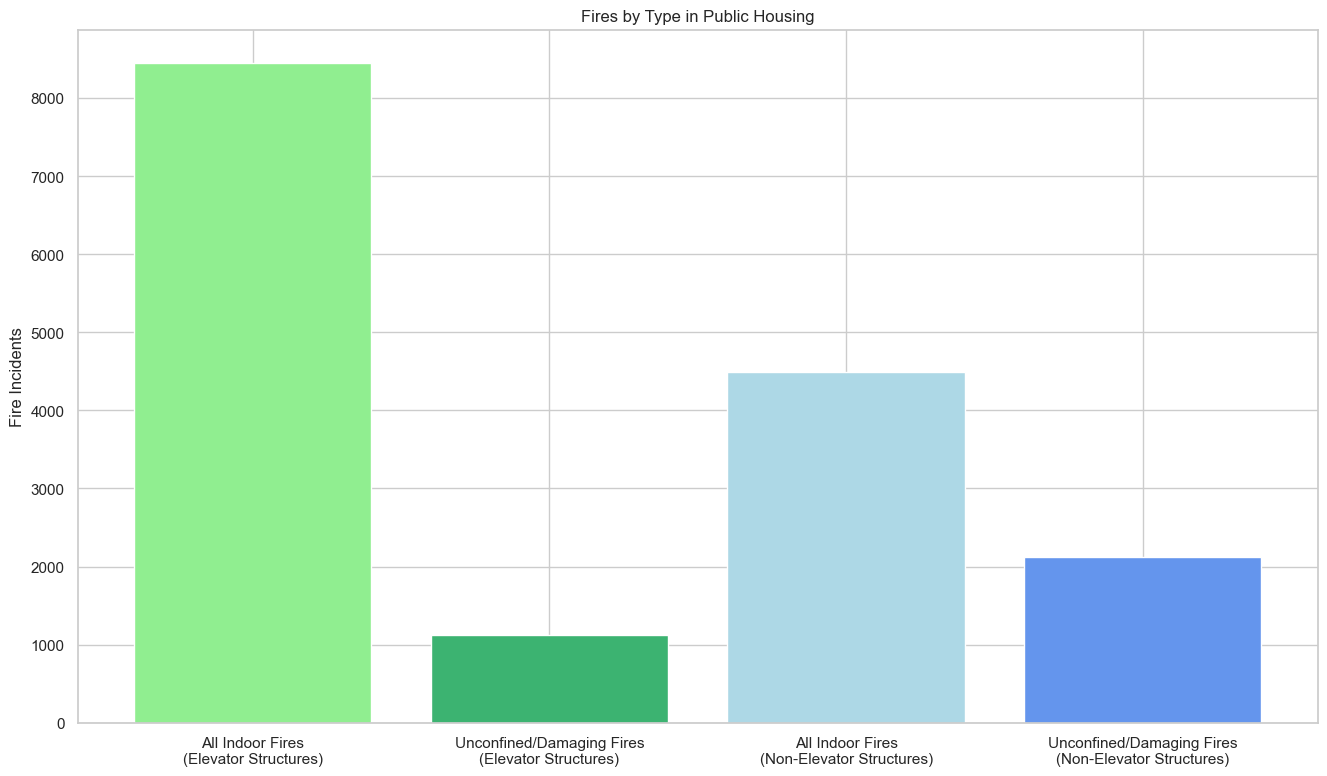

In [ ]:
# Calculate the sums
sum_es_building_fires = es['building_fires_total'].sum()
sum_nes_building_fires = nes['building_fires_total'].sum()
sum_es_111 = es['unconfined_or_damaging'].sum()
sum_nes_111 = nes['unconfined_or_damaging'].sum()

# Prepare data
categories = ['All Indoor Fires\n(Elevator Structures)', 'Unconfined/Damaging Fires\n(Elevator Structures)', 'All Indoor Fires\n(Non-Elevator Structures)', 'Unconfined/Damaging Fires\n(Non-Elevator Structures)']
sums = [sum_es_building_fires, sum_es_111, sum_nes_building_fires, sum_nes_111]

# Set Seaborn style
sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(16,9))
plt.bar(categories, sums, color=['lightgreen', 'mediumseagreen', 'lightblue', 'cornflowerblue'])
plt.ylabel('Fire Incidents')
plt.title('Fires by Type in Public Housing')
plt.show()
